In [1]:
import misc
from plots import *
from datetime import timedelta
import copy

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from logparser import LogReader, PosReader

# Prepare the data

### Load log files

In [2]:

logs = []

logs.append(misc.getLogDictionnary(
    "Google Pixel 7",
    "../.data/2023_Dataset_Hervanta/3_dynamic_campus/Google_Pixel7/log_GooglePixel7_20230801110405.txt",
    "mimir"
))

logs.append(misc.getLogDictionnary(
    "Google Pixel Watch",
    "../.data/2023_Dataset_Hervanta/3_dynamic_campus/Google_PixelWatch/log_GooglePixelWatch_20230801110404.txt",
    "mimir"
))

logs.append(misc.getLogDictionnary(
    "Xiaomi 11T",
    "../.data/2023_Dataset_Hervanta/3_dynamic_campus/Xiaomi_11T/log_Xiaomi11T_20230801111451.txt",
    "mimir"
))

logs.append(misc.getLogDictionnary(
    "OnePlus Nord 2",
    "../.data/2023_Dataset_Hervanta/3_dynamic_campus/OnePlus_Nord2/log_OneplusNord2_20230811103018.txt",
    "mimir"
))

logs.append(misc.getLogDictionnary(
    "Samsung A52",
    "../.data/2023_Dataset_Hervanta/3_dynamic_campus/Samsung_A52/log_SamsungA52_20230811101903.txt",
    "mimir"
))


# logs.append(misc.getLogDictionnary(
#     "OnePlus Nord 2",
#     "../.data/dynamic_campus/log_mimir_OneplusNord2_20230811103018.txt",
#     "mimir"
# ))

# logs.append(misc.getLogDictionnary(
#     "OnePlus Nord 2 (Backpack)",
#     "../.data/dynamic_campus/log_mimir_OneplusNord2_Backpack_20230811101814.txt",
#     "mimir"
# ))

# logs.append(misc.getLogDictionnary(
#     "Samsung A52",
#     "../.data/dynamic_campus/log_mimir_SamsungA52_20230811101903.txt",
#     "mimir"
# ))

# logs.append(misc.getLogDictionnary(
#     "Samsung A52 (Backpack)",
#     "../.data/dynamic_campus/log_mimir_SamsungA52_Backpack_20230811102920.txt",
#     "mimir"
# ))

# Parse log - This might take a while...
for log in logs:
    log['content'] = LogReader(log['filepath'], ['Raw', 'Fix'], log['mode'])

In [3]:
# Set reference position
filepath = "../example_data/NMND17420010S_2023-08-01_08-24-35.pos"
ref = PosReader(filepath)

Compute ENU errors

In [4]:

#ref_enu = [61.449219, 23.856267, 166.0]

ref_enu = [61.44922404, 23.8562781, 162.711]

for log in logs:
    log['content'].fix[["east", "north", "up"]] = log['content'].fix.apply(
        lambda row: misc.convert2ENU(row['latitude'], row['longitude'], row['altitude'], ref_enu), 
        axis='columns', result_type='expand')
    
    log['content'].fix[["2D_error"]] = log['content'].fix.apply(
        lambda row: misc.getHorizontalError(row['east'], row['north']), 
        axis='columns', result_type='expand')
    
    log['content'].fix[["3D_error"]] = log['content'].fix.apply(
        lambda row: misc.get3DError(row['east'], row['north'], row['up']), 
        axis='columns', result_type='expand')

Compute doppler/phase error

# Analysis

## Positions

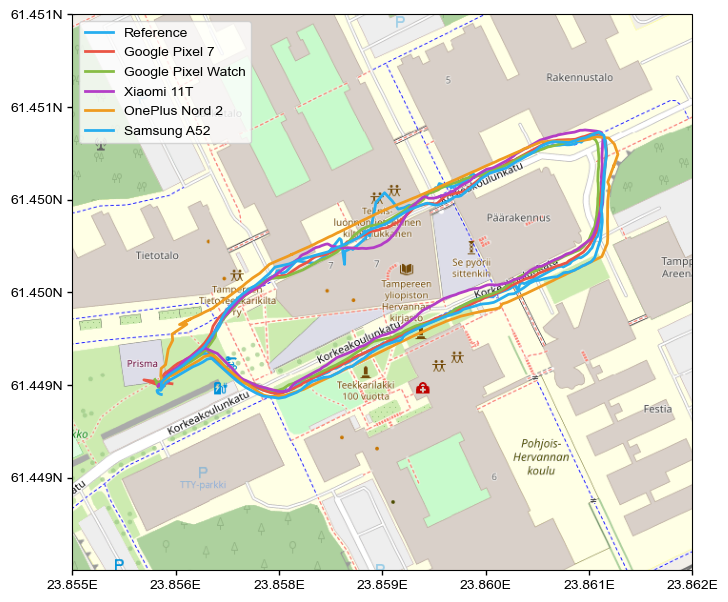

In [5]:
center = [61.449219, 23.856267]
#extent = [center[1] - 0.02, center[1] + 0.005, center[0] - 0.005, center[0] + 0.005]
extent = [center[1] - 0.001, center[1] + 0.006, center[0] - 0.001, center[0] + 0.002]

locations = {}
locations["Reference"] = ref.pos
for log in logs:
    locations[log['device_name']] = log['content'].fix.loc[log['content'].fix['provider'].isin(['GPS']), ["latitude", "longitude"]]

plotMap(locations=locations, extent=extent, scale=17)

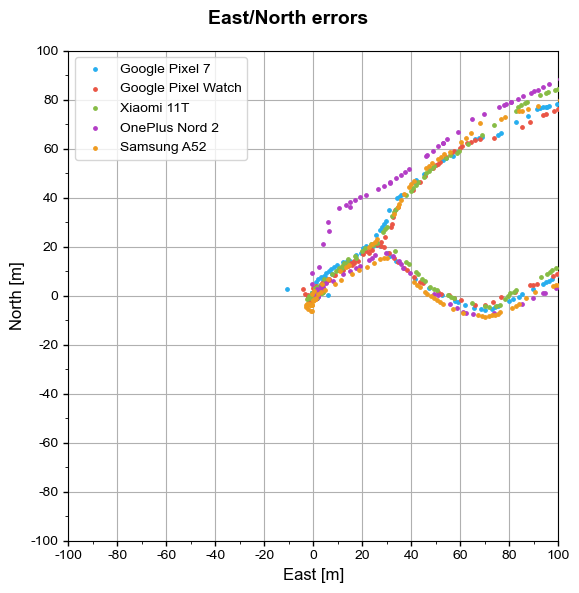

In [6]:
plotEN(logs, lim=100, ticks=[10, 20])

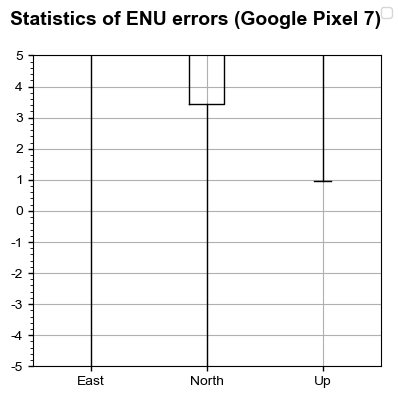

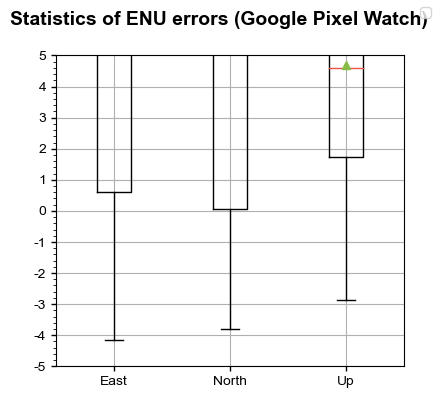

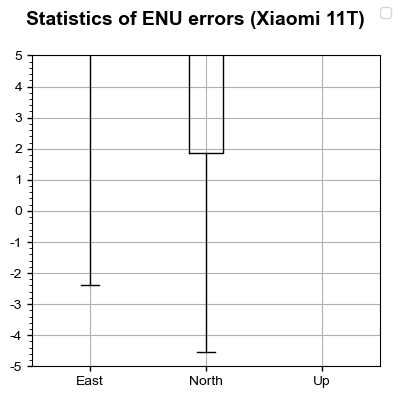

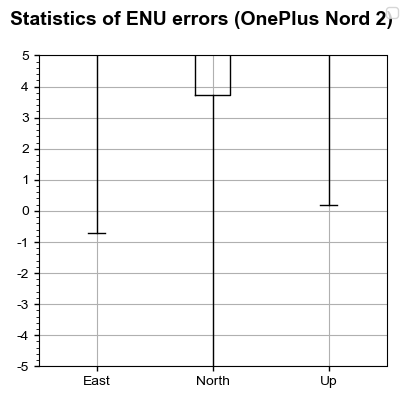

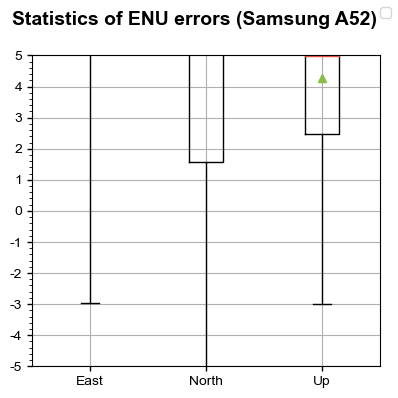

In [7]:
plotStatisticsENU(logs, mode='box')

## Measurements

### Pseudoranges

As the pseudoranges generation performed is highly simplified, there might be some outliers present. We remove them by applying some quantile filtering.

In [8]:
_logs = copy.deepcopy(logs)
for log in _logs:
    log['content'].raw = misc.filterValues(log['content'].raw, 'PseudorangeAcceleration', 300)

Rows removed 7 (0.058%)
Rows removed 15 (0.165%)
Rows removed 131 (0.733%)
Rows removed 90 (0.648%)
Rows removed 2 (0.022%)


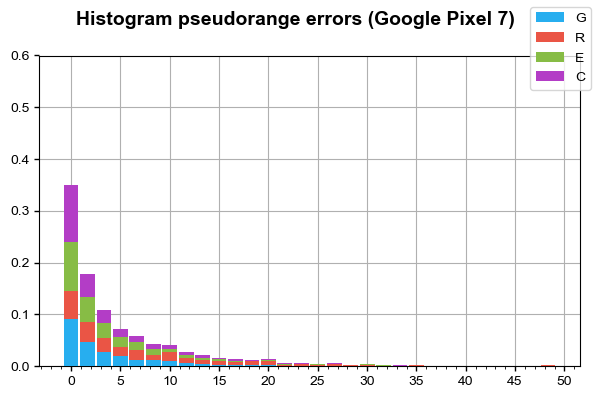

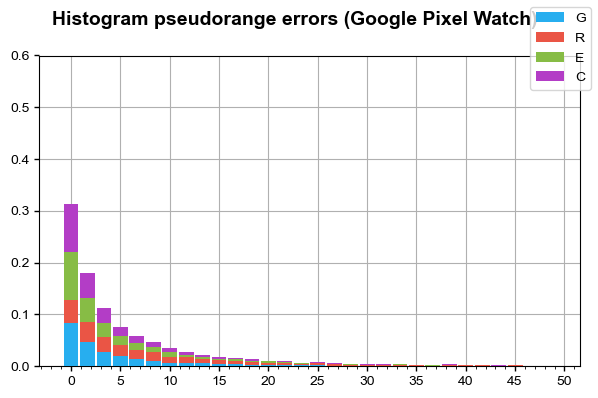

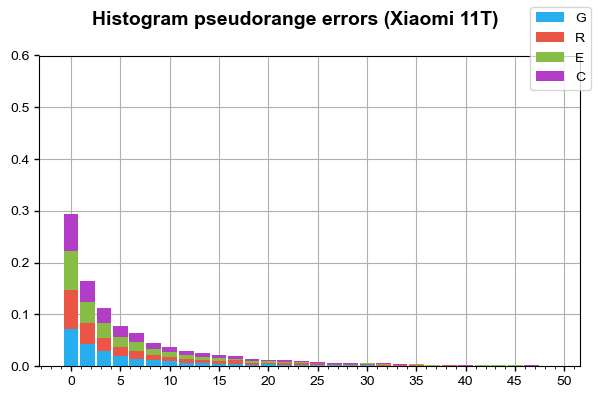

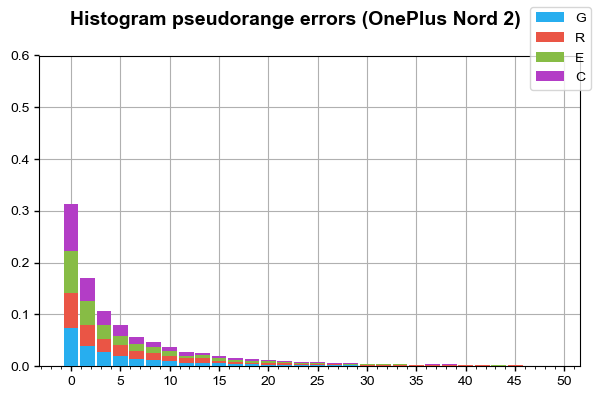

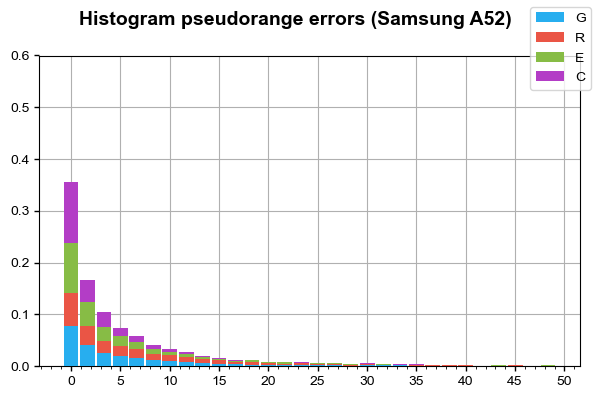

In [9]:
plotHistPerSystem(_logs, ('G', 'R', 'E', 'C'), 'PseudorangeAcceleration', ticks=[1,5], lim=[50, 0.6], absolute=True)

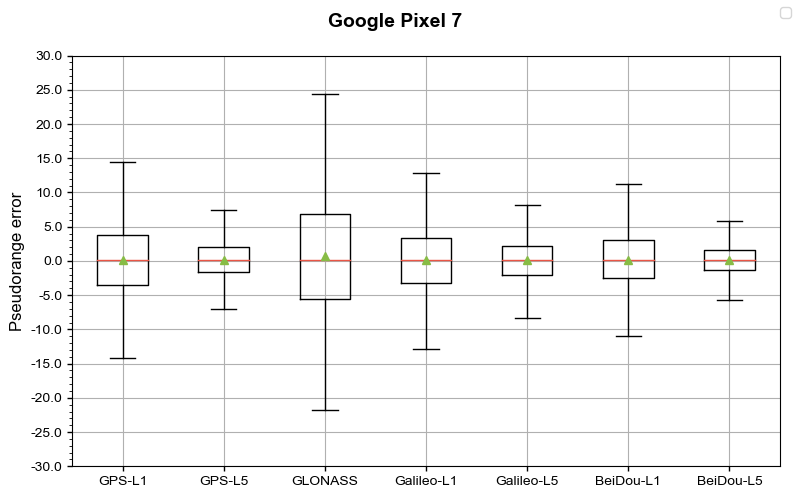

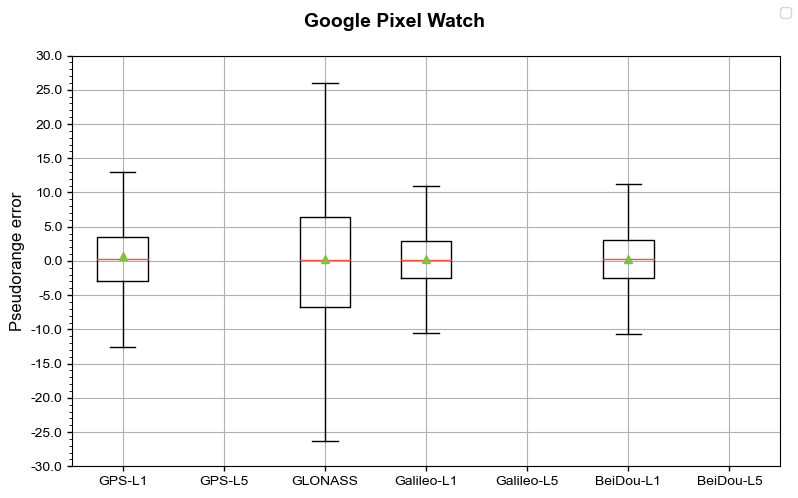

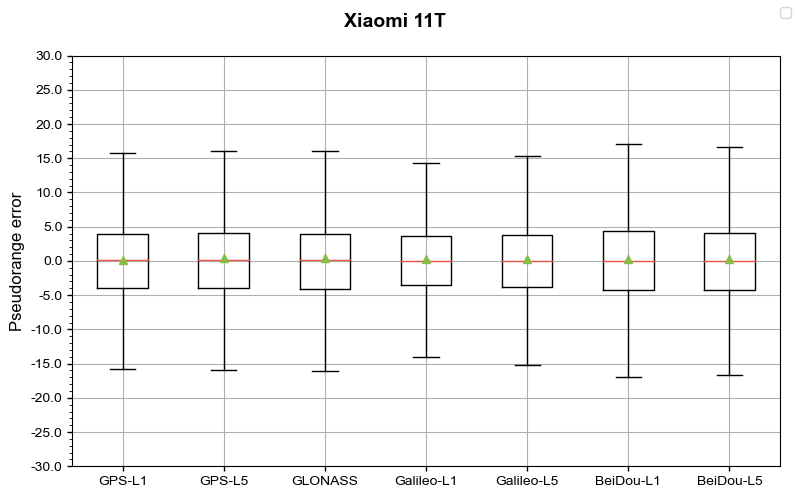

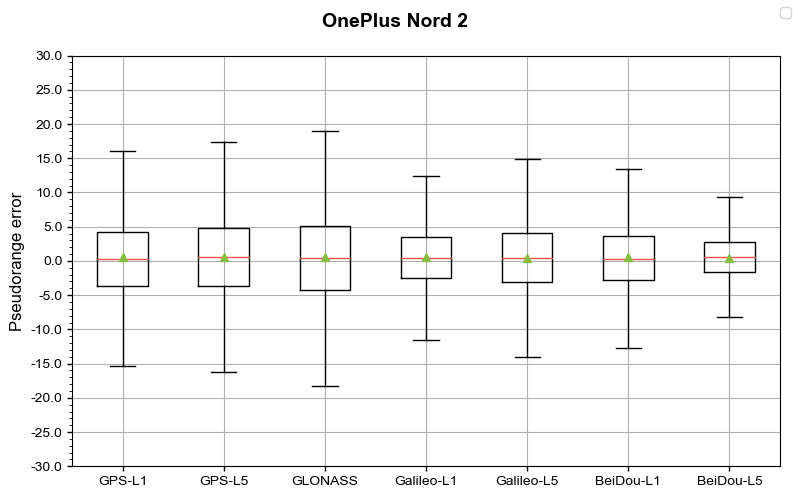

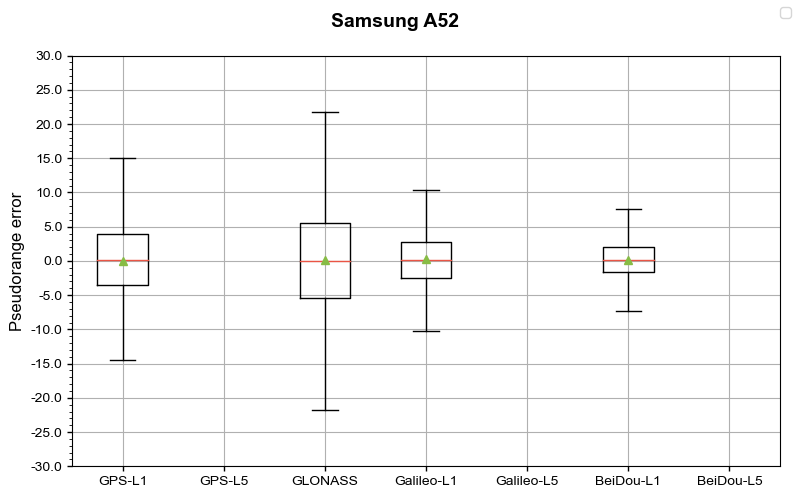

In [10]:
plotStatisticsDataBox(_logs, 
                      'PseudorangeAcceleration', 
                      'Pseudorange error', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=30,
                      ticks=[1,5])

### Doppler

In [11]:
_logs = copy.deepcopy(logs)
for log in _logs:
    log['content'].raw = misc.filterValues(log['content'].raw, 'DopplerError', 300)

Rows removed 0 (0.000%)
Rows removed 0 (0.000%)
Rows removed 0 (0.000%)
Rows removed 0 (0.000%)
Rows removed 0 (0.000%)


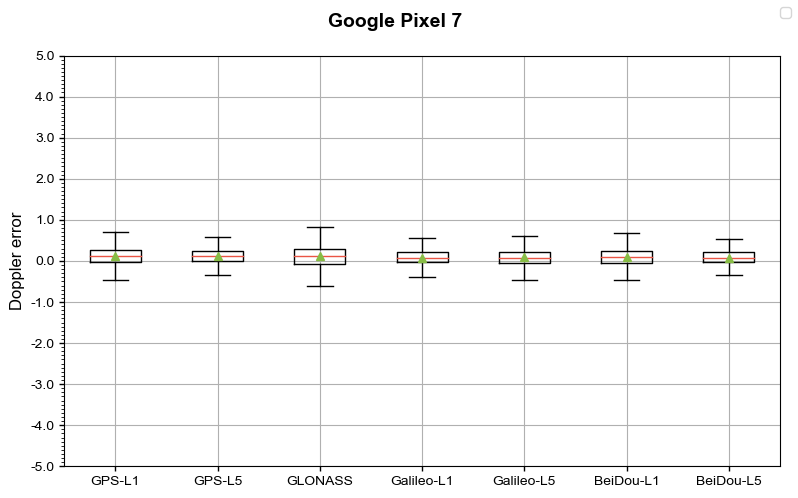

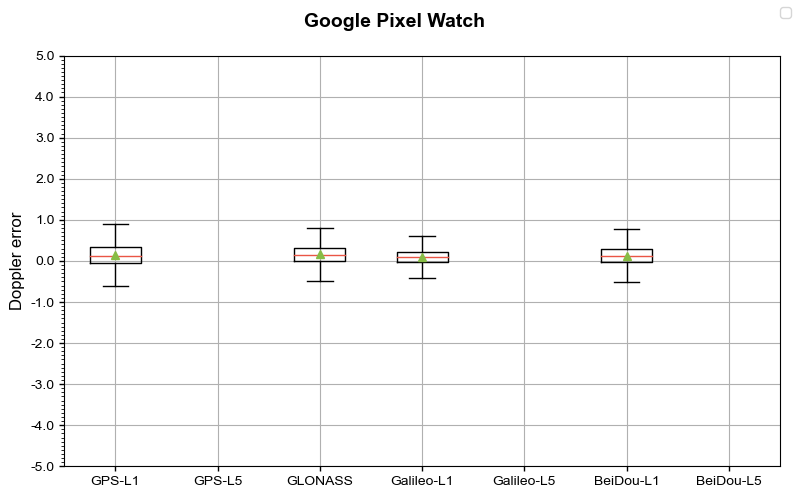

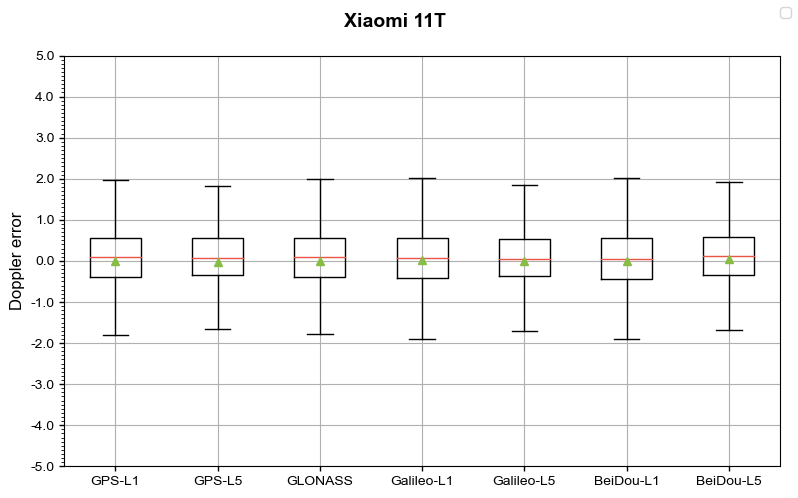

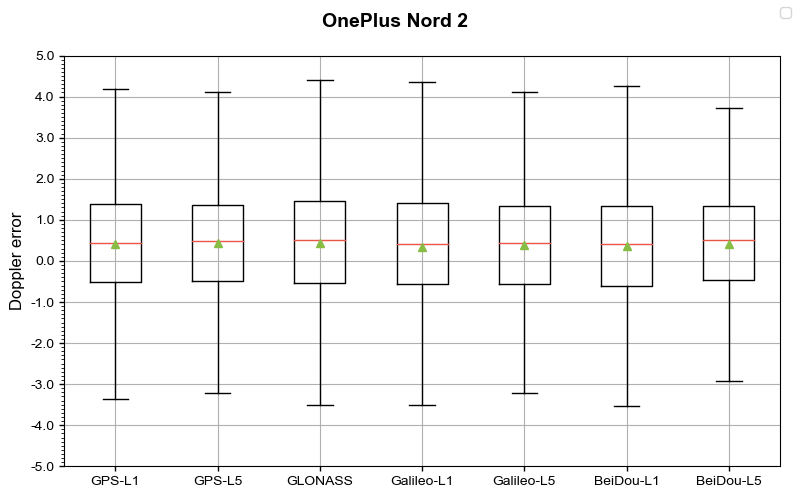

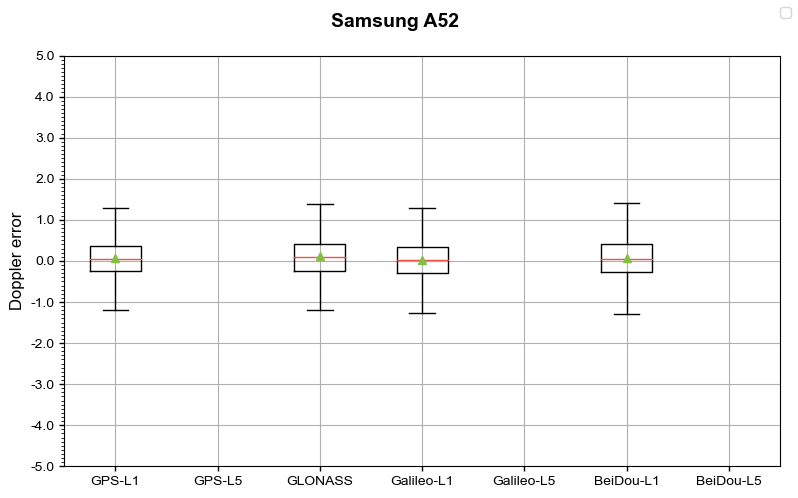

In [12]:
plotStatisticsDataBox(
    _logs, 
    'DopplerError', 
    'Doppler error', 
    ('G', 'R', 'E', 'C'), 
    ('L1', 'L5'),
    lim=5,
    ticks=[0.1,1])

### Phase

In [13]:
_logs = copy.deepcopy(logs)
# for log in _logs:
#     log['content'].raw = misc.filterValues(log['content'].raw, 'PhaseError', 300)

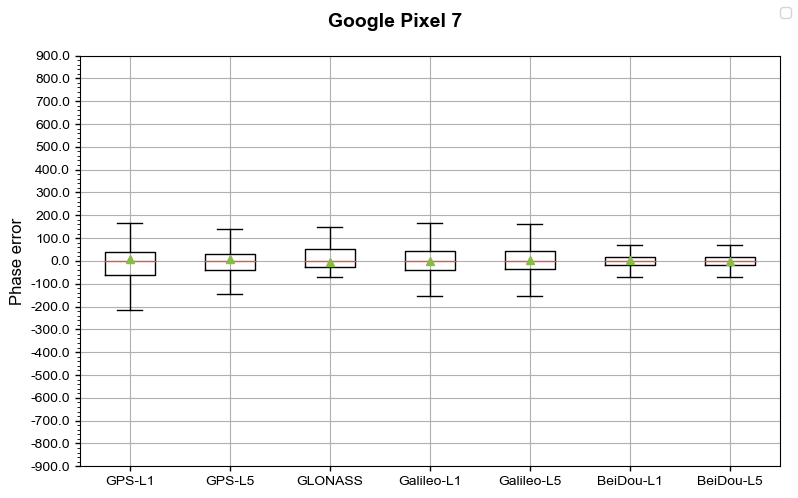

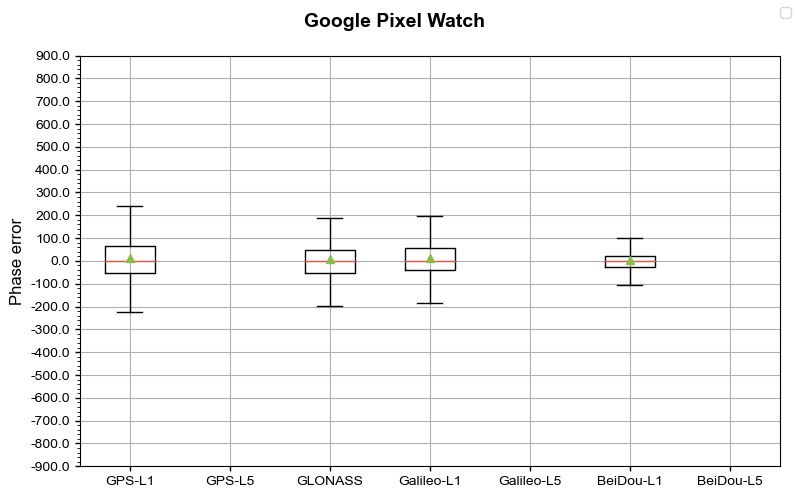

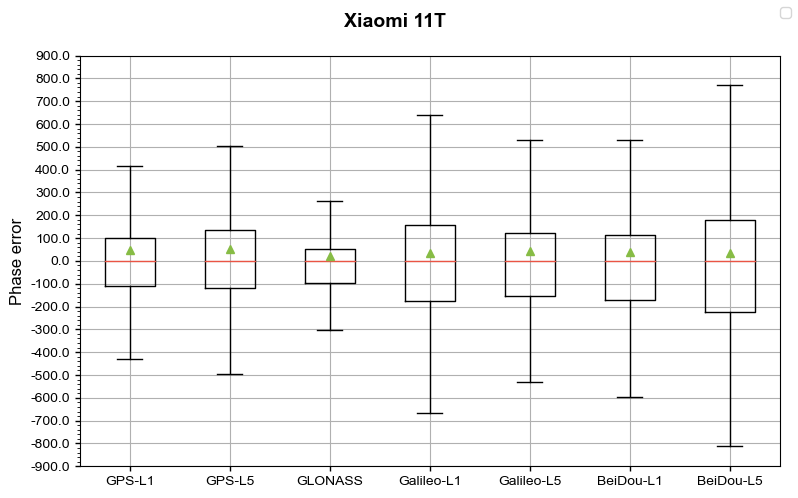

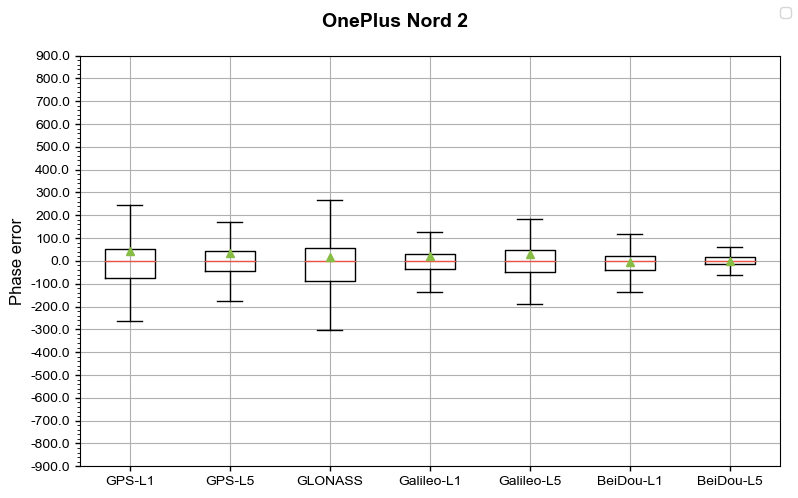

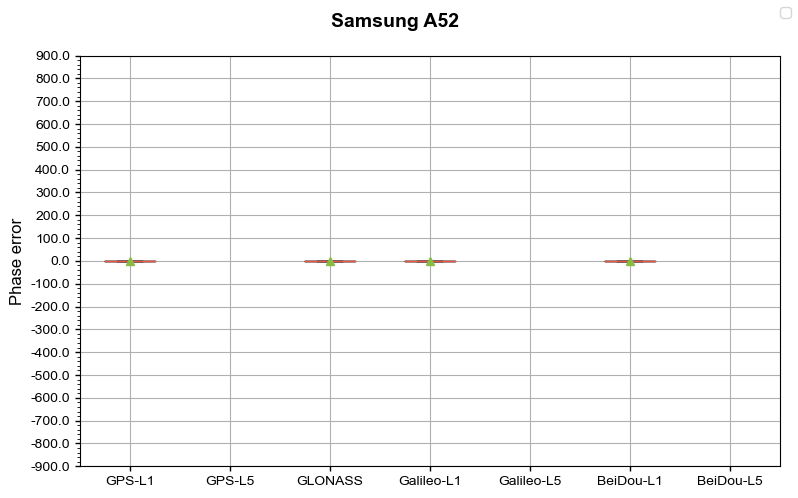

In [14]:
plotStatisticsDataBox(
    _logs, 
    'PhaseError', 
    'Phase error', 
    ('G', 'R', 'E', 'C'), 
    ('L1', 'L5'),
    lim=900,
    ticks=[20,100])

In [15]:
def plotState():
    return

In [16]:
_logs[0]['content'].raw['AccumulatedDeltaRangeState'].value_counts

<bound method IndexOpsMixin.value_counts of 16       16
6        16
14       16
27       16
106      17
         ..
12560    17
12624    21
12646    16
12668    21
12774    17
Name: AccumulatedDeltaRangeState, Length: 12789, dtype: int64>

### C/N0

In [17]:
_logs = copy.deepcopy(logs)

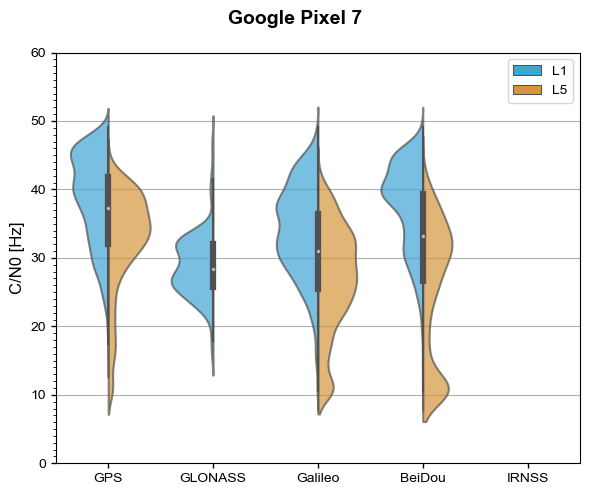

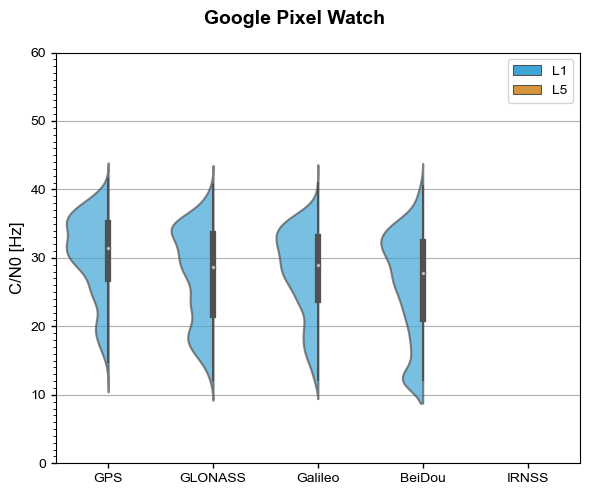

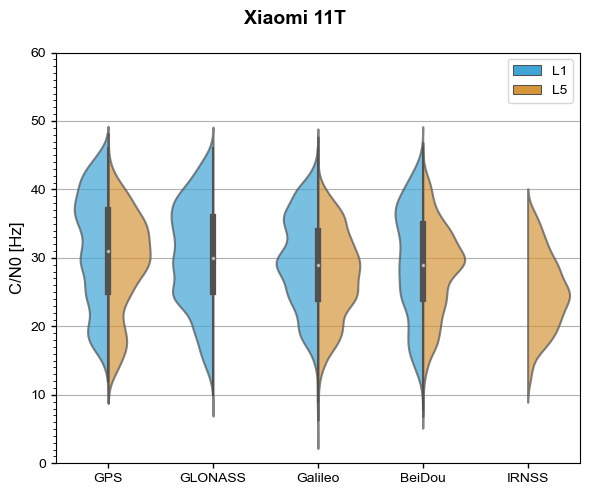

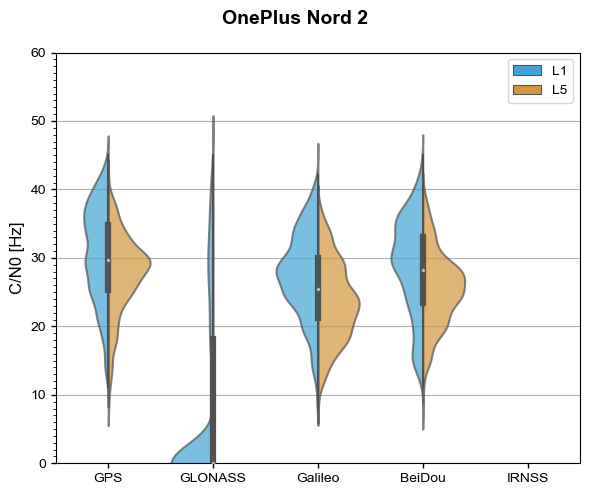

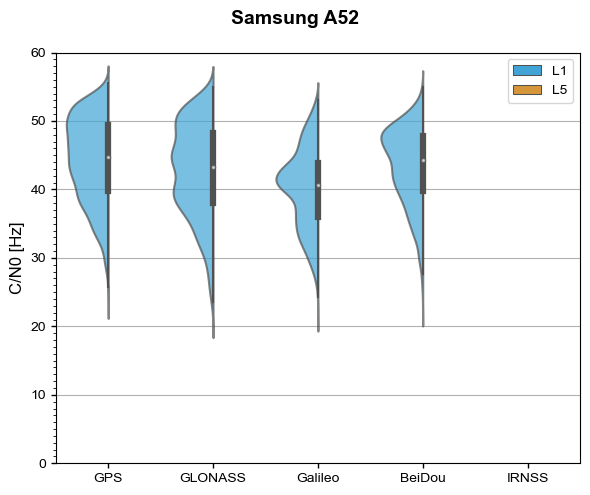

In [18]:
plotStatisticsDataViolin(
    _logs, 
    'Cn0DbHz', 
    'C/N0 [Hz]', 
    ('G', 'R', 'E', 'C', 'I', 'S', 'J'), 
    ('L1', 'L5'),
    lim=60,
    ticks=[1,10])